In [1]:
import numpy as np
import pandas as pd
import os
import warnings
from tqdm import tqdm
import math
import seaborn as sns

from scipy.stats import gamma
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
# import optperfprofpy

import sys 
sys.path.append('..')
from utils.demand_pkg import *
import matplotlib.pyplot as plt
from utils.algorithms import get_opt, get_EQ, get_end2end_iid, get_end2end, get_normal_basestock, get_gamma_basestock, get_normal_basestock2

import tensorflow as tf

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [2]:
o0 = pd.read_csv('../data/1320_feature/features_v12.csv', parse_dates=['create_tm','complete_dt','dt','next_complete_dt'],
                 usecols=lambda col: col not in ['d_vlt'])

In [3]:
df_sales = pd.read_csv('../data/1320/rdc_sales_1320_replenishment_V1_filled_pp.csv')
df_sl = df_sales.set_index('row')
df_sl.rename(columns=lambda x: (dt.datetime(2016,1,1) + dt.timedelta(days=int(x)-730)).date(), inplace=True)

In [4]:
o0['IS_over_mean_56'] = (o0['initial_stock_overall'] / o0['mean_56']).replace(np.inf, 0).fillna(0)
o0['overall_opt_order_for_opt'] = o0['overall_opt_order'].copy()

In [5]:
o1 = o0.copy()

# o1.insert(1, 'sku_id', o1['item_sku_id'])
o1.loc[:,'sku_id'] = o1['item_sku_id'].apply(lambda x: x.split('#')[0])

In [6]:
# o_num = o2.loc[:, feature_list+LABEL]
# for i in range(2, o_num.shape[1]):
#     plt.figure();
#     ax = sns.distplot(o_num.iloc[:,i]);
#     plt.savefig('../figures/vlm/%i.png' %i);
#     plt.close();

In [7]:
sku_set = o1.sku_id.unique()
sku_train, sku_test = train_test_split(sku_set, random_state=10, train_size=0.9, test_size=0.1)

In [8]:
IDX = ['item_sku_id','sku_id']

CAT_FEA = [
#     'item_first_cate_cd', 'item_second_cate_cd', 
    'item_third_cate_cd', 
    'int_org_num', 
#     'brand_code', 
#     'create_day_of_week'
    ]

VLT_FEA = [
#            'review_period', 
    'uprc', 'contract_stk_prc', 
#     'wt', 'width', 'height', 'calc_volume', 'len',
#     'vlt_count', 'vlt_sum', 'vlt_min', 'vlt_max', 'vlt_mean', 'vlt_std',
    'qtty_sum', 'qtty_min', 'qtty_max', 'qtty_mean', 'qtty_std', 
#     'amount_sum', 'amount_min', 'amount_max', 'amount_mean', 'amount_std', 
    'vlt_count_6mo', 'vlt_sum_6mo', 'vlt_min_6mo', 'vlt_max_6mo', 'vlt_mean_6mo', 'vlt_std_6mo',
#     'vendor_vlt_count', 'vendor_vlt_sum', 'vendor_vlt_min', 'vendor_vlt_max', 'vendor_vlt_mean', 'vendor_vlt_std', 
#     'vendor_vlt_count_6mo', 'vendor_vlt_sum_6mo', 'vendor_vlt_min_6mo', 
#     'vendor_vlt_max_6mo', 'vendor_vlt_mean_6mo', 'vendor_vlt_std_6mo', 
#     'vendor_qtty_sum', 'vendor_qtty_min', 'vendor_qtty_max', 
#     'vendor_qtty_mean', 'vendor_qtty_std', 'vendor_amount_sum',
#     'vendor_amount_min', 'vendor_amount_max', 'vendor_amount_mean'
        ]

SF_FEA = [
#         'q_7', 'q_14', 'q_28', 'q_56', 'q_112', 
        'mean_3', 'mean_7', 'mean_14', 'mean_28', 'mean_56', 'mean_112', 
#         'diff_140_mean', 'mean_140_decay', 'median_140', 'min_140', 'max_140', 'std_140', 
#         'diff_60_mean', 'mean_60_decay', 'median_60', 'min_60', 'max_60', 'std_60', 
        'diff_30_mean', 'mean_30_decay', 'median_30', 'min_30', 'max_30', 'std_30', 
#         'diff_14_mean', 'mean_14_decay', 'median_14', 'min_14', 'max_14', 'std_14',
#         'diff_7_mean', 'mean_7_decay', 'median_7', 'min_7', 'max_7', 'std_7',
        'diff_3_mean', 'mean_3_decay', 'median_3', 'min_3', 'max_3', 'std_3',
#         'has_sales_days_in_last_140', 'last_has_sales_day_in_last_140',
#         'first_has_sales_day_in_last_140', 'has_sales_days_in_last_60',
#         'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
#         'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
#         'first_has_sales_day_in_last_30', 'has_sales_days_in_last_14',
#         'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
#         'has_sales_days_in_last_7', 'last_has_sales_day_in_last_7', 'first_has_sales_day_in_last_7'
            ]
   
MORE_FEA =[
           'review_period', 
           'normal', 
           'gamma', 
            'eq'
            ]

IS_FEA = [
#            'initial_stock', 
#            'IS_over_mean_56'
        ]
    
# LABEL = ['target_decision']    
LABEL = ['demand_RV']    


o1[CAT_FEA] = o1[CAT_FEA].astype('category')

# o1 = o0[VLT_CAT_FEA_COLS + VLT_NUM_FEA_COLS]

o_dummy = pd.get_dummies(o1[CAT_FEA])
len_dummy = o_dummy.shape[1]
o1 = pd.concat([o1, o_dummy], axis=1)
o2 = o1.drop(CAT_FEA, axis=1)

CAT_FEA_HOT = list(o2.columns)[-len_dummy:]

In [9]:
feature_list =  VLT_FEA + SF_FEA + MORE_FEA + IS_FEA + CAT_FEA_HOT

In [10]:
# o1 = o1[(o1['target_decision'] > o1['target_decision'].quantile(0.01)) & (o1['target_decision'] < o1['target_decision'].quantile(0.98))]
# o1 = o1[(o1['initial_stock'] > o1['initial_stock'].quantile(0.01)) & (o1['initial_stock'] < o1['initial_stock'].quantile(0.98))]

In [11]:
low_qtl = o1[VLT_FEA + SF_FEA + MORE_FEA].quantile(0.01)
hgh_qtl = o1[VLT_FEA + SF_FEA + MORE_FEA].quantile(0.98)
o2 = o2.copy()
o2.loc[:, VLT_FEA + SF_FEA + MORE_FEA] = o1[VLT_FEA + SF_FEA + MORE_FEA].clip(low_qtl, hgh_qtl, axis=1)

In [12]:
# Remove outliers
o2r = o2[o2[LABEL[0]]<=o2[LABEL[0]].quantile(0.99)]

In [13]:
df_train = o2r[o2r['sku_id'].isin(sku_train)]
df_test = o2r[o2r['sku_id'].isin(sku_test)]

X_train_ns, y_train_ns, id_train = df_train[feature_list], df_train[LABEL], df_train[IDX]
X_test_ns, y_test_ns, id_test = df_test[feature_list], df_test[LABEL], df_test[IDX]

n_train, n_test = len(X_train_ns), len(X_test_ns)

In [14]:
print(X_train_ns.mean_7.mean(), X_test_ns.mean_7.mean())

21.17255381689934 23.170218058204128


In [15]:
X_scaler = MinMaxScaler() # For normalizing dataset
y_scaler = MinMaxScaler() # For normalizing dataset
# We want to predict Close value of stock 
X_train = pd.DataFrame(X_scaler.fit_transform(X_train_ns), columns=X_train_ns.columns)
y_train = pd.DataFrame(y_scaler.fit_transform(y_train_ns), columns=y_train_ns.columns)

X_test = pd.DataFrame(X_scaler.transform(X_test_ns), columns=X_test_ns.columns)
y_test = pd.DataFrame(y_scaler.transform(y_test_ns), columns=y_test_ns.columns)
# pd.DataFrame(min_max_scaler.inverse_transform(y_test), columns=y_test.columns)

In [16]:
X_train_ns.columns

Index(['uprc', 'contract_stk_prc', 'qtty_sum', 'qtty_min', 'qtty_max',
       'qtty_mean', 'qtty_std', 'vlt_count_6mo', 'vlt_sum_6mo', 'vlt_min_6mo',
       'vlt_max_6mo', 'vlt_mean_6mo', 'vlt_std_6mo', 'mean_3', 'mean_7',
       'mean_14', 'mean_28', 'mean_56', 'mean_112', 'diff_30_mean',
       'mean_30_decay', 'median_30', 'min_30', 'max_30', 'std_30',
       'diff_3_mean', 'mean_3_decay', 'median_3', 'min_3', 'max_3', 'std_3',
       'review_period', 'normal', 'gamma', 'eq', 'item_third_cate_cd_1591',
       'item_third_cate_cd_2677', 'item_third_cate_cd_5022',
       'item_third_cate_cd_5024', 'int_org_num_3', 'int_org_num_4',
       'int_org_num_5', 'int_org_num_6', 'int_org_num_9', 'int_org_num_10',
       'int_org_num_316', 'int_org_num_772'],
      dtype='object')

In [17]:
y_scaler.data_max_

array([5281.])

In [18]:
y_scaler.scale_[0], X_scaler.scale_[-13]

(0.0001893580761219466, 0.00041419007284551417)

In [19]:
# mean = X_train_ns.mean(axis=0)
# std = X_train_ns.std(axis=0)
# X_train = (X_train_ns - mean) / std
# X_test = (X_test_ns - mean) / std

In [103]:
cat_dim = len(CAT_FEA_HOT)
vlt_dim = len(VLT_FEA)
sf_dim = len(SF_FEA)
oth_dim = len(MORE_FEA)
is_dim = len(IS_FEA)
input_dim =  vlt_dim + sf_dim + oth_dim + is_dim + cat_dim

hidden_dim = [[50, 60], 80, 20]

output_dim = 1
q = 0.9


tf.reset_default_graph()
tf.set_random_seed(0)

with tf.name_scope('Data'):
    x_vlt = tf.placeholder(tf.float32, shape=[None, vlt_dim], name='Input_vlt')
    x_sf = tf.placeholder(tf.float32, shape=[None, sf_dim], name='Input_sf')
    x_cat = tf.placeholder(tf.float32, shape=[None, cat_dim], name='Input_pf')
    x_oth = tf.placeholder(tf.float32, shape=[None, oth_dim], name='Input_more')
    x_is = tf.placeholder(tf.float32, shape=[None, is_dim], name='Input_IS')
    mean_vlt = tf.expand_dims(x_vlt[:,11],1, name='mean_vlt')
    review_p = tf.expand_dims(x_oth[:,0],1, name='review_p')

with tf.name_scope('Label'):
    y = tf.placeholder(tf.float32, shape=[None, 1], name='Label')


with tf.variable_scope('Layer_1_vlt'):
    W1_vlt = tf.Variable(tf.truncated_normal([vlt_dim+cat_dim, hidden_dim[0][0]], stddev=0.001), name='Weight_1_vlt')
    b1_vlt = tf.Variable(tf.zeros([hidden_dim[0][0]]), name='Bias_1_vlt')
    l1_vlt = tf.add(tf.matmul(tf.concat([x_vlt, x_cat], axis=1), W1_vlt), b1_vlt)
    l1_vlt = tf.nn.relu(l1_vlt)

with tf.variable_scope('Layer_1_sf'):
    W1_sf = tf.Variable(tf.truncated_normal([sf_dim+cat_dim, hidden_dim[0][1]], stddev=0.001), name='Weight_1_sf')
    b1_sf = tf.Variable(tf.zeros([hidden_dim[0][1]]), name='Bias_1_sf')
    l1_sf = tf.add(tf.matmul(tf.concat([x_sf, x_cat], axis=1), W1_sf), b1_sf)
    l1_sf = tf.nn.relu(l1_sf)
    
# with tf.variable_scope('Layer_1_profile'):
#     W1_pf = tf.Variable(tf.truncated_normal([cat_dim, hidden_dim[0][2]], stddev=0.001), name='Weight_1_pf')
#     b1_pf = tf.Variable(tf.zeros([hidden_dim[0][2]]), name='Bias_1_pf')
#     l1_pf = tf.add(tf.matmul(x_cat, W1_pf), b1_pf)
#     l1_pf = tf.nn.relu(l1_pf)

with tf.variable_scope('Layer_2'):
    W2 = tf.Variable(tf.truncated_normal([hidden_dim[0][0]+hidden_dim[0][1]+oth_dim, hidden_dim[1]], stddev=0.001), name='Weight_2')
    b2 = tf.Variable(tf.zeros([hidden_dim[1]]), name='Bias_3')
    l2 = tf.add(tf.matmul(tf.concat([l1_vlt, l1_sf, x_oth], axis=1), W2), b2)
    l2 = tf.nn.relu(l2)

with tf.variable_scope('Layer_3'):
    W3 = tf.Variable(tf.truncated_normal([hidden_dim[1], hidden_dim[2]], stddev=0.001), name='Weight_3')
    b3 = tf.Variable(tf.zeros([hidden_dim[2]]), name='Bias_3')
    l3 = tf.add(tf.matmul(tf.concat([l2], axis=1), W3), b3)
    l3 = tf.nn.relu(l3)

with tf.variable_scope('Layer_final'):
    W4 = tf.Variable(tf.truncated_normal([hidden_dim[2], 1], stddev=0.001), name='Weight_4')
    b4 = tf.Variable(tf.zeros([1]), name='Bias_4')
    output = tf.add(tf.matmul(tf.concat([l3, x_is], axis=1), W4), b4)
    error = y - output
#     loss = tf.reduce_mean(tf.square(tf.maximum(q*error, (q-1)*error)) )
    c_os = tf.multiply(q*error, review_p + mean_vlt ) * 0.5
    c_hd = (q-1)*error
    loss = tf.reduce_mean(tf.maximum(c_os, c_hd) )

with tf.name_scope('Optimizer'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


In [104]:
epochs = 20
batch_size = 64
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter("output", sess.graph)
writer.close()


train_err = sess.run(loss, feed_dict={x_vlt: X_train[VLT_FEA].values, 
                                     x_sf: X_train[SF_FEA].values, 
                                     x_oth: X_train[MORE_FEA].values, 
                                     x_cat: X_train[CAT_FEA_HOT].values, 
                                     x_is: X_train[IS_FEA].values, 
                                     y: y_train.values})
test_err = sess.run(loss, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                     x_sf: X_test[SF_FEA].values, 
                                     x_oth: X_test[MORE_FEA].values, 
                                     x_cat: X_test[CAT_FEA_HOT].values, 
                                     x_is: X_test[IS_FEA].values, 
                                     y: y_test.values})
print(0, train_err, test_err)
for epoch in range(epochs):
    # Split data to batches
    train_err = 0
    for idx in range(0, X_train.shape[0], batch_size):
        bs = min(idx + batch_size, n_train) - idx
        batch_data = X_train.iloc[idx:bs+idx, :]
        batch_labels = y_train.iloc[idx:bs+idx, :]
        feed_dict = {x_vlt: batch_data[VLT_FEA].values, 
                     x_sf: batch_data[SF_FEA].values, 
                     x_oth: batch_data[MORE_FEA].values,
                     x_cat: batch_data[CAT_FEA_HOT].values,
                     x_is: batch_data[IS_FEA].values,
                     y: batch_labels}
        _, c_loss = sess.run([train_step, loss], feed_dict)
        train_err += c_loss*bs
    test_err = sess.run(loss, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                         x_sf: X_test[SF_FEA].values, 
                                         x_oth: X_test[MORE_FEA].values, 
                                         x_cat: X_test[CAT_FEA_HOT].values, 
                                         x_is: X_test[IS_FEA].values, 
                                         y: y_test.values})
    print(epoch+1, train_err/n_train, test_err)

0 0.011302222 0.012461871
1 0.00448303575545313 0.0032490622
2 0.002754830489162958 0.0031530473
3 0.0026907561885745226 0.0030997507
4 0.002639386122002705 0.003061452
5 0.002596213310189028 0.003030743
6 0.002556584173431535 0.0029986373
7 0.0025194847089463307 0.002979304
8 0.0024879918760792913 0.0029585294
9 0.0024589330899369055 0.002956283
10 0.0024347491641265313 0.0029331439
11 0.002411954489871877 0.0029149249
12 0.0023923453293148143 0.0028973294
13 0.002373152264211291 0.0028922933
14 0.002355392389006926 0.0028917876
15 0.0023381751896311156 0.0028866713
16 0.0023248675880167325 0.0028608069
17 0.002309997720513632 0.0028512874
18 0.0022961216312035707 0.0028408826
19 0.0022834865441277467 0.002825795
20 0.0022715309601383264 0.0028144936


In [105]:
pred = sess.run(output, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                  x_sf: X_test[SF_FEA].values, 
                                  x_oth: X_test[MORE_FEA].values, 
                                  x_cat: X_test[CAT_FEA_HOT].values, 
                                  x_is: X_test[IS_FEA].values, 
                                  })

pred = pd.DataFrame(y_scaler.inverse_transform(pred), columns=['prediction']).fillna(0)

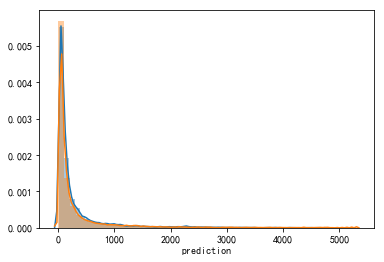

In [106]:
sns.distplot(pred['prediction']);
sns.distplot(y_test_ns);

In [107]:
# gbm = lgb.LGBMRegressor(alpha=0.9, objective='quantile', max_depth = -10, num_leaves=31, learning_rate=0.05, 
#                         n_estimators=2000, 
#                         subsample=0.7,
#                         silent=1,
#                         seed=0 )

# gbm.fit(X_train, y_train.values.T[0], eval_set=(X_test, y_test.values.T[0])) 

In [108]:
gbm_pred=gbm.predict(X_test) 

In [109]:
gbm_pred = pd.DataFrame(y_scaler.inverse_transform(gbm_pred.reshape(-1, 1)), columns=['prediction']).fillna(0)
# gbm_pred = pd.DataFrame(gbm_pred.reshape(-1, 1), columns=['prediction']).fillna(0)

In [110]:
h = 1
b = 9

In [111]:
o4 = df_test.copy()
o4.reset_index(drop=True, inplace=True)

In [112]:
o4['demand_RV_list'] = o4.apply(lambda x: df_sl.loc[x['item_sku_id'], \
                                            x['create_tm'].date():x['next_complete_dt'].date()].values\
                            if x['item_sku_id'] in df_sl.index else [], axis=1)

o4['demand_RV_list_acm'] = o4['demand_RV_list'].apply(lambda x: np.cumsum(x))

In [113]:
list_c = ['SKU_DC', 'create_tm', 'OPT', 'E2E_NN', 'E2E_GBM', 'EQ',  'Normal', 'Gamma', 'Hist', 
          'Ave_sales','Std_sales', 
#           'Ave_review', 'Std_review'
         ]
numberOfRows = len(o4)

df_cost = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_holding = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_back = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_stockout = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_turnover = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)

In [114]:
df_cost['SKU_DC']=df_holding['SKU_DC']=df_back['SKU_DC']=df_stockout['SKU_DC']=df_turnover['SKU_DC']=o4['item_sku_id'].values
df_cost['create_tm']=df_holding['create_tm']=df_back['create_tm']=df_stockout['create_tm']=df_turnover['create_tm']=o4['create_tm'].values
df_cost['Ave_sales']=df_holding['Ave_sales']=df_back['Ave_sales']=df_stockout['Ave_sales']=df_turnover['Ave_sales']=o4['mean_112'].values
df_cost['Std_sales']=df_holding['Std_sales']=df_back['Std_sales']=df_stockout['Std_sales']=df_turnover['Std_sales']=o4['std_140'].values

In [115]:
def get_inv(x, name):
    inv1, inv2 = [], []
 
    for t in range(len(x['demand_RV_list_acm'])):
        if t < np.ceil(x['vlt_actual']):
            inv1.append(x['initial_stock']-x['demand_RV_list_acm'][t])
            continue
        else:
#             if inv[-1] <= 0:
#                 inv.append(-x['demand_RV_list'][t])
#             else:
#                 inv.append(inv[-1] - x['demand_RV_list'][t])
            inv_ = x[name]+x['initial_stock']-x['demand_RV_list_acm'][t]
            inv1.append(inv_)
            inv2.append(inv_)
    return [inv1, inv2]
    
Z90 = 1.96
o4['OPT_inv_f'], o4['OPT_inv'] = zip(*o4.apply(lambda x: get_inv(x, 'target_decision'), axis=1))

o4['EQ_replen'] = pd.read_csv('EQ_replen_with_IS.csv')
o4['EQ_replen'] = (o4['EQ_replen'] - o4['initial_stock']).clip(0)
o4['EQ_inv_f'], o4['EQ_inv'] = zip(*o4.apply(get_inv, name='EQ_replen', axis=1))

o4['Normal_replen'] = o4.apply(lambda x: int(x['mean_112']*(x['review_period']+x['vendor_vlt_mean'])
                                       +Z90*np.sqrt((x['review_period']+x['vendor_vlt_mean'])*x['std_140']**2
                                                    + x['std_140']**2 * x['vlt_std'])), axis=1)
o4['Normal_replen'] = (o4['Normal_replen'] - o4['initial_stock']).clip(0)
o4['Normal_inv_f'], o4['Normal_inv'] = zip(*o4.apply(get_inv, name='Normal_replen',  axis=1))

def gamma_base(x):
    mean = x['mean_112']
    var = x['std_140']**2
    theta = var/(mean+1e-5)
    k = mean/(theta+1e-5)
    k_sum = int(x['review_period']+x['vendor_vlt_mean'])*k
    gamma_stock = gamma.ppf(0.9, a=k_sum, scale = theta)
    if(np.isnan(gamma_stock)):
        return 0
    else:
        return int(gamma_stock)

o4['Gamma_replen'] = o4.apply(gamma_base, axis=1)
o4['Gamma_replen'] = (o4['Gamma_replen'] - o4['initial_stock']).clip(0)
o4['Gamma_inv_f'],o4['Gamma_inv'] = zip(*o4.apply(get_inv, name='Gamma_replen', axis=1))

o4['Hist_inv_f'], o4['Hist_inv'] = zip(*o4.apply(get_inv, name='actual_pur_qtty', axis=1))


In [116]:
o4['gbm_pred'] = (gbm_pred['prediction'] - o4['initial_stock']).clip(0)
# o4['gbm_pred'] = gbm_pred['prediction'].clip(0)
o4['E2E_GBM_inv_f'], o4['E2E_GBM_inv'] = zip(*o4.apply(get_inv, name='gbm_pred',  axis=1))

o4['nn_pred'] = (pred['prediction'] - o4['initial_stock']).clip(0)
# o4['nn_pred'] = pred['prediction'].clip(0)
o4['E2E_NN_inv_f'], o4['E2E_NN_inv'] = zip(*o4.apply(get_inv, name='nn_pred', axis=1))

In [117]:
# o4['demand_EQ_list'] = o4.apply(lambda x: df_sl.iloc[:,360:].loc[x['item_sku_id'], \
#                                             :x['create_tm'].date()].values\
#                             if x['item_sku_id'] in df_sl.index else [], axis=1)
# o4['EQ_replen_with_IS'] = o4.apply(lambda x: np.percentile(
#                             [np.sum(x['demand_EQ_list'][i:i+int(x['review_period']+x['vendor_vlt_mean'])])
#                                      for i in range(int(len(x['demand_EQ_list'])-x['review_period']-x['vendor_vlt_mean']))
#                             ], 90), axis=1)
# o4['EQ_replen_with_IS'] = o4['EQ_replen_with_IS'] - o4['initial_stock_overall']
# o4['EQ_replen_with_IS'].to_csv('EQ_replen_with_IS.csv', index=False)
# o4['EQ_replen_with_IS'] = pd.read_csv('EQ_replen_with_IS.csv')


In [118]:
str_list = ['OPT', 'E2E_NN', 'E2E_GBM', 'EQ', 'Normal', 'Gamma', 'Hist']
for str1 in str_list:
    str2 = str1 + '_inv'
    df_holding[str1] = o4[str2].apply(lambda x: h * sum([inv for inv in x if inv>0]) )
#     df_back[str1] = o4[str2].apply(lambda x: b * sum([-inv for inv in x if inv<0]) )
    df_back[str1] = o4[str2].apply(lambda x: b * (0 if  x==[] else max(0, -x[-1])))
    df_stockout[str1] = o4[str2].apply(lambda x: len([inv for inv in x if inv<0])/len(x) if len(x)>0 else 0 )
    df_turnover[str1] = o4.apply(lambda x: np.mean([max(i,0) for i in x[str2]]) / x['mean_112']
                                  if np.mean(x['mean_112']) >0 else np.mean(x[str2]), axis=1).fillna(7)
    df_cost[str1] = df_holding[str1] + df_back[str1]

In [119]:
pd.DataFrame({'Best': df_cost.iloc[:,3:9].idxmin(axis=1).value_counts()/len(df_cost)}).T

,E2E_NN,Hist,Gamma,EQ,E2E_GBM,Normal
Best,0.339856,0.271371,0.125114,0.118398,0.097007,0.048255


In [120]:
pd.DataFrame({'Total': df_cost[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Holding': df_holding[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Back': df_back[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Stockout': df_stockout[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Turnover': df_turnover[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             }).T

,OPT,E2E_NN,E2E_GBM,EQ,Normal,Gamma,Hist,Ave_sales
Total,959.150568,1524.774817,1556.880192,5067.905771,2337.760136,1992.108697,1574.354117,21.344102
Holding,959.150568,1279.238399,1407.728994,4558.411226,2212.000415,1807.381477,1207.003234,21.344102
Back,0.000000,245.536417,149.151198,509.494544,125.759721,184.727220,367.350883,21.344102
Stockout,0.000000,0.101895,0.061461,0.175182,0.058249,0.100721,0.234471,21.344102
Turnover,6.383452,15.335047,13.285219,201.062388,16.378515,12.776500,10.736846,21.344102


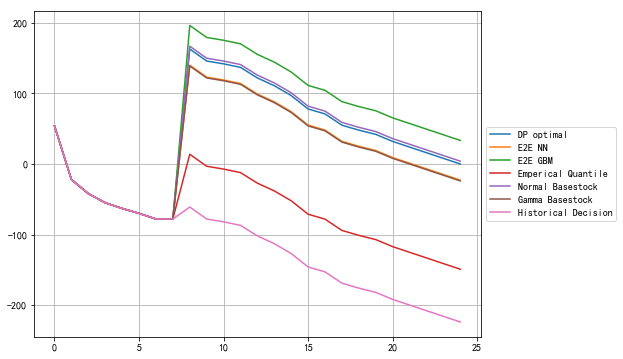

In [102]:
tt = o4.iloc[305,:]
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(tt['OPT_inv_f'], label = 'DP optimal')
ax1.plot(tt['E2E_NN_inv_f'], label = 'E2E NN')
ax1.plot(tt['E2E_GBM_inv_f'], label = 'E2E GBM')
ax1.plot(tt['EQ_inv_f'], label = 'Emperical Quantile')
ax1.plot(tt['Normal_inv_f'], label = 'Normal Basestock')
ax1.plot(tt['Gamma_inv_f'], label = 'Gamma Basestock')
ax1.plot(tt['Hist_inv_f'], label = 'Historical Decision')
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax1.grid(True)

In [ ]:
co_qtl = df_cost.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)
hd_qtl = df_holding.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)
bk_qtl = df_back.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(co_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(co_qtl.columns[:-2], loc=0)
ax.set_title('total cost不同分位点下不同模型的表现');

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(hd_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(hd_qtl.columns[:-2], loc=0)
ax.set_title('holding cost不同分位点下不同模型的表现');

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(bk_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.set_xlim(0, 1)
ax.legend(bk_qtl.columns[:-2], loc=0)
ax.set_title('backorder cost不同分位点下不同模型的表现');

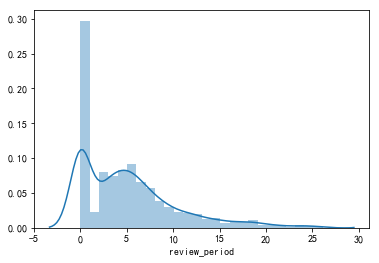

In [297]:
# sns.distplot(np.log(df_cost['Ave_sales']));
sns.distplot(o4.groupby('item_sku_id').review_period.std().fillna(0))

In [259]:
# py_pp = df_cost
# py_pp['SKU_DC'] = py_pp[['SKU_DC','create_tm']].apply(lambda x: '_'.join([str(i) for i in x]), axis=1)
# py_pp.drop(columns=['create_tm','Ave_sales','Std_sales'], inplace=True)
# py_pp_stack = py_pp.set_index('SKU_DC').stack().rename('method')
# py_pp_stack = pd.DataFrame(py_pp_stack).reset_index()
# taus, solver_vals, solvers, transformed_data = optperfprofpy.calc_perprof(py_pp_stack.iloc[0:770,:], ['SKU_DC'], ['method'], ['level_1'])
# optperfprofpy.draw_simple_pp(taus, solver_vals, solvers)

In [260]:
# import shap
# # print the JS visualization code to the notebook
# shap.initjs()

In [261]:
# explainer = shap.TreeExplainer(gbm)
# shap_values = explainer.shap_values(X_test)

# shap.summary_plot(shap_values, X_test)

# shap.summary_plot(shap_values, X_test, plot_type="bar")

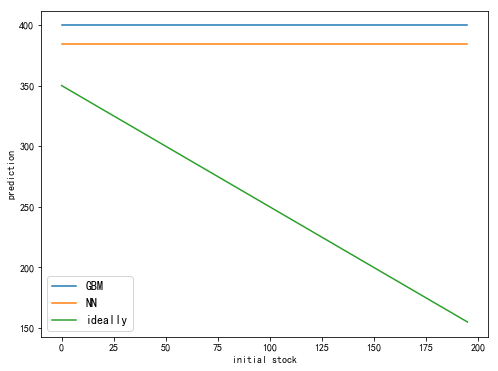

In [515]:
xx = np.arange(0, 200, 5)
tt_is = X_test_ns.iloc[305:306,:]
yy1, yy2 = [],[]
for i in xx:
#     tt_is['initial_stock'] = i
    tt_ = pd.DataFrame(X_scaler.transform(tt_is), columns=tt_is.columns)

    gbm_pred=gbm.predict(tt_) 
    nn_pred=sess.run(output, feed_dict={x_vlt: tt_[VLT_FEA].values, 
                                  x_sf: tt_[SF_FEA].values, 
                                  x_oth: tt_[MORE_FEA].values, 
                                  x_cat: tt_[CAT_FEA_HOT].values, 
                                  x_is: tt_[IS_FEA].values, 
                                  })
    yy1.append( y_scaler.inverse_transform(gbm_pred.reshape(-1, 1))[0][0] )
    yy2.append( y_scaler.inverse_transform(nn_pred.reshape(-1, 1))[0][0] )

fig, ax1 = plt.subplots(figsize=(8, 6))
plt.plot(xx, yy1, label='GBM');
plt.plot(xx, yy2, label='NN');
plt.plot(xx, 350-xx, label='ideally');

# plt.plot(xx, 330-xx)
plt.xlabel('initial stock')
plt.ylabel('prediction')
plt.legend(prop={'size': 12})

In [201]:
sess.close()